<a href="https://colab.research.google.com/github/biancagiovannafernandes/Machine-Learning/blob/main/Projet_MLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparative Analysis of SVM, k-NN, and Ensemble Learning for Breast Tissue Classification**

This project presents a supervised machine learning framework for breast tissue classification based on handcrafted feature extraction. Three classification approaches are investigated: Support Vector Machines (SVM), k-Nearest Neighbors (k-NN), and an ensemble strategy combining both methods. Using a labeled dataset, the models aim to distinguish between different pathological states by learning discriminative decision boundaries in a high-dimensional feature space. The study evaluates and compares the performance of these methods, highlighting how feature-based learning and ensemble techniques contribute to robust and reliable computer-aided medical diagnosis, particularly in scenarios involving limited datasets.

#Upload of the data and traitement

In [118]:
from google.colab import drive
drive.mount('/content/drive')
import skimage
from skimage import io
import os
import cv2
import numpy as np
import seaborn as sns
from skimage import transform
from skimage.feature import local_binary_pattern
from skimage.measure import shannon_entropy
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Organization of the dataset

In [119]:
train_dir = '/content/drive/MyDrive/Soukayna Bianca/MLIP/Covid19-dataset/train'
classes = ['Normal', 'Covid', 'Viral Pneumonia']
mapping = {'Normal': 0, 'Covid': 1, 'Viral Pneumonia': 2}

train_images = []
train_labels = []

for label in classes:
    path = os.path.join(train_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img_res = cv2.resize(img, (224, 224))
            img_gray = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
            train_images.append(img_gray)
            train_labels.append(mapping[label])

X_train = np.array(train_images) / 255 #normalization
y_train = np.array(train_labels)

test_dir = '/content/drive/MyDrive/Soukayna Bianca/MLIP/Covid19-dataset/test'

test_images = []
test_labels = []

for label in classes:
    path = os.path.join(test_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img_res = cv2.resize(img, (224, 224))
            img_gray = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
            test_images.append(img_gray)
            test_labels.append(mapping[label])

X_test = np.array(test_images) / 255 #normalization
y_test = np.array(test_labels)

Validate_dir = '/content/drive/MyDrive/Soukayna Bianca/MLIP/Covid19-dataset/validation'

val_images = []
val_labels = []

for label in classes:
    path = os.path.join(Validate_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img_res = cv2.resize(img, (224, 224))
            img_gray = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
            val_images.append(img_gray)
            val_labels.append(mapping[label])

X_val = np.array(val_images) / 255 #normalization
y_val = np.array(val_labels)

In [120]:
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("X_val   :", X_val.shape)

X_train : (222, 224, 224)
X_test  : (66, 224, 224)
X_val   : (29, 224, 224)


Clean the memory

In [121]:
del train_images
del train_labels
del val_images
del val_labels
del test_images
del test_labels

## **Tomography exemples**

As illustrated in the images below, the distinction between healthy and diseased lungs is primarily associated with the presence of mucus within the rib cage. In computed tomography (CT) scans, mucus appears as whitish regions with irregular texture patterns. These visual characteristics motivate the selection of the features used by our machine learning system to perform image classification.

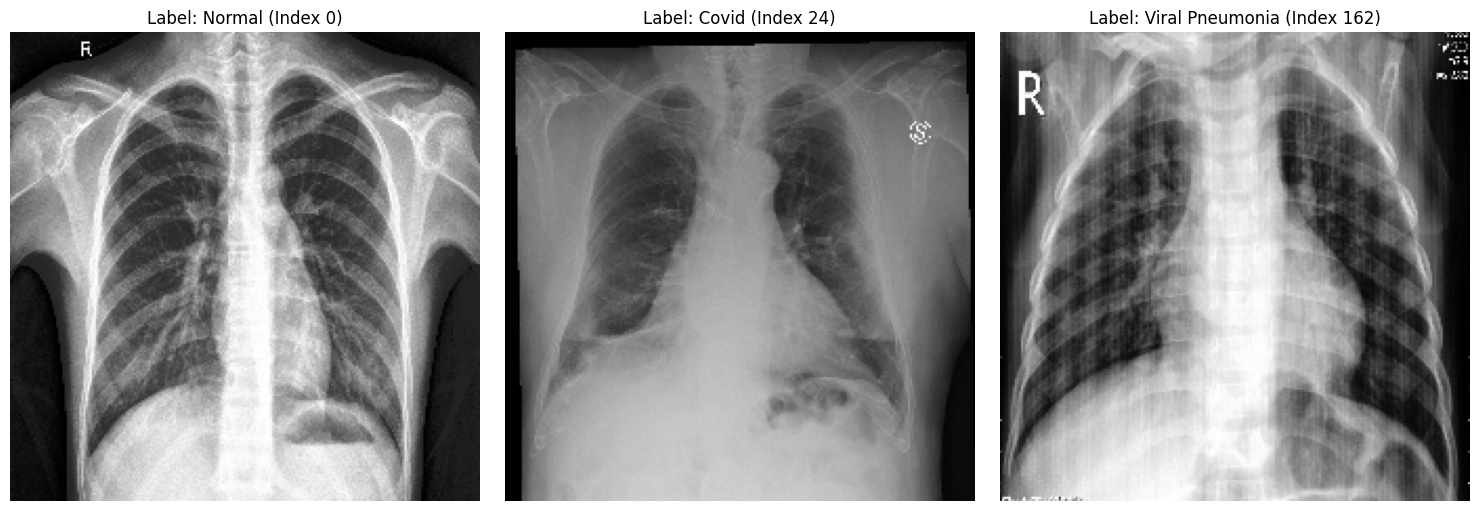

In [122]:
plt.figure(figsize=(15, 5))

for i, class_name in enumerate(classes):
    indices = np.where(y_train == i)[0]

    if len(indices) > 0:
        img_idx = indices[0]

        plt.subplot(1, 3, i + 1)
        plt.imshow(X_train[img_idx], cmap='gray')
        plt.title(f"Label: {class_name} (Index {img_idx})")
        plt.axis('off')

plt.tight_layout()
plt.show()

# **Feature Extraction**
The next step is selecting the specific features we will use for our classification. To distinguish between healthy lungs, pneumonia, and COVID-19, we typically look for 'whitish' areas in the images.

A healthy lung should appear mostly black because it is filled with air. In contrast, a lung with COVID-19 often shows a 'ground-glass' pattern, which looks like hazy, blurred white patches. A lung with pneumonia typically shows more solid, dense white areas called consolidations, where the infection has filled the air sacs with fluid.

Therefore, the methods we decided to use to distinguish them were:

### **Luminance Histogram:**
This function counts the number of pixels at each brightness level. It allows us to detect if there are more white pixels than expected, indicating potential abnormalities in lung density.

### **LBP (Local Binary Pattern):**
This compares each pixel with its neighbors to capture the underlying texture. An inflamed lung has a much rougher and more complex texture compared to the smooth, clear appearance of a healthy lung.

### **Hu Moments:**
This method describes the overall shape
and structural geometry of the lung images. It allows the system to recognize if the disease is physically distorting the lung's internal structure, regardless of its size or orientation in the image.


In [123]:
def extract_hist_features(image_array):
    features = []

    for img in image_array:

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        if len(img.shape) == 3 and img.shape[2] == 1:
            img = img.squeeze(axis=2)

        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        y_channel = img_yuv[:, :, 0]

        hist = cv2.calcHist([y_channel], [0], None, [32], [0, 256])
        cv2.normalize(hist, hist)

        features.append(hist.flatten())
    return np.array(features)


def extract_texture_features(image_array):
    texture_features = []

    radius = 3
    n_points = 8 * radius
    n_bins = n_points + 2

    for img in image_array:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        if len(img.shape) == 3 and img.shape[2] == 1:
            gray = img.squeeze(axis=2)
        elif len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img

        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        texture_features.append(hist)

    return np.array(texture_features)

def extract_hu_moments(image_array):

    hu_features = []

    for img in image_array:
        if img.dtype != np.uint8:
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

        if len(img.shape) == 3 and img.shape[2] == 1:
            img = img.squeeze(axis=2)
        elif len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        moments = cv2.moments(img)
        hu = cv2.HuMoments(moments).flatten()
        hu_features.append(hu)

    return np.array(hu_features)

def extract_density_features(image_array):
    density_features = []
    for img in image_array:

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

        if len(img.shape) == 3 and img.shape[2] == 1:
            img = img.squeeze(axis=2)
        elif len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        total_pixels = img.size
        dark_pixels = np.sum(thresh == 0)
        ratio = dark_pixels / total_pixels

        density_features.append([ratio, np.mean(thresh), np.std(thresh)])

    return np.array(density_features)

def extract_intensity_features(image_array):

    features = []
    for img in image_array:
        if img.dtype != np.uint8:
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)

        if len(img.shape) == 3 and img.shape[2] == 1:
            img = img.squeeze(axis=2)

        elif len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        mean_val = np.mean(img)
        std_val  = np.std(img)
        skew_val = skew(img.flatten())
        kurt_val = kurtosis(img.flatten())
        entropy_val = shannon_entropy(img)
        features.append([mean_val, std_val, skew_val, kurt_val, entropy_val])

    return np.array(features)

def print_histogram(features_matrix, index):
    plt.figure(figsize=(8, 4))
    plt.bar(range(32), features_matrix[index])
    plt.title(f"Histogram of Luminance - Imagem {index}")
    plt.xlabel("Bins (Levels of grey)")
    plt.ylabel(" Normalized Frequency")
    plt.show()

def plot_svm_2d(X, y, kernel='linear'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    model = SVC(kernel=kernel)
    model.fit(X_pca, y)

    h = .02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(f"SVM {kernel.capitalize()} - PCA 2D Projection")
    plt.show()

## **Application in the DATA**

In [124]:
Hist_train = extract_hist_features(X_train)
Hist_test  = extract_hist_features(X_test)
Hist_val   = extract_hist_features(X_val)

Texture_train = extract_texture_features(X_train)
Texture_test  = extract_texture_features(X_test)
Texture_val   = extract_texture_features(X_val)

Density_train = extract_density_features(X_train)
Density_test  = extract_density_features(X_test)
Density_val   = extract_density_features(X_val)

Intensity_train = extract_intensity_features(X_train)
Intensity_test  = extract_intensity_features(X_test)
Intensity_val   = extract_intensity_features(X_val)

Hu_train = extract_hu_moments(X_train)
Hu_test  = extract_hu_moments(X_test)
Hu_val   = extract_hu_moments(X_val)


In the image bellow we can see the difference of histogram betwen 2 images of different classes

Hist_train (number of images, bins): (222, 32)


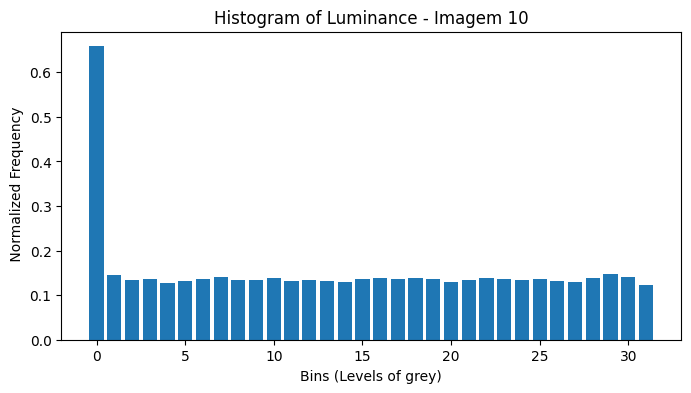

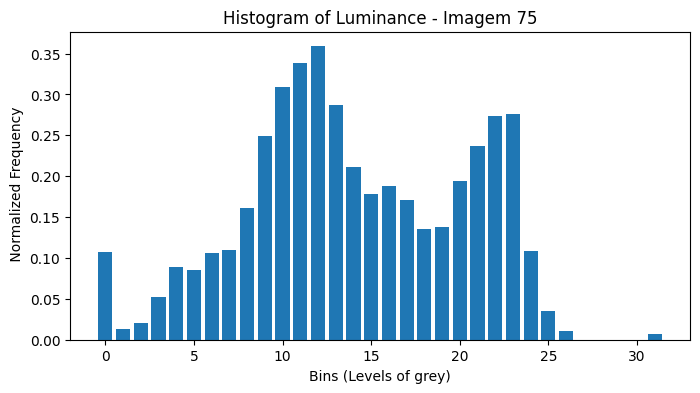

In [125]:
print(f"Hist_train (number of images, bins): {Hist_train.shape}")
print_histogram(Hist_train, 10)
print_histogram(Hist_train, 75)

## **Selection of features**

At this stage, we evaluate whether the selected features effectively perform on the images in our dataset.

In [126]:
X_train_features = np.hstack((Hist_train, Texture_train, Hu_train, Density_train, Intensity_train))
X_test_features  = np.hstack((Hist_test, Texture_test, Hu_test, Density_test, Intensity_test))
X_val_features   = np.hstack((Hist_val, Texture_val, Hu_val, Density_val, Intensity_val))

from imblearn.over_sampling import SMOTE

X_train = np.nan_to_num(X_train_features)
X_test  = np.nan_to_num(X_test_features)
X_val   = np.nan_to_num(X_val_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_val_scaled   = scaler.transform(X_val)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [127]:
from sklearn.ensemble import RandomForestClassifier
def diagnostic_feature_importance(X_train, y_train, features_names, groups):
    """
    Uses Random Forest to diagnose the predictive power of each feature group.
    """
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    df_all_features = pd.DataFrame({'feature': features_names, 'importance': importances})

    group_results = []
    for group_name, columns in groups.items():
        total_importance = df_all_features[df_all_features['feature'].isin(columns)]['importance'].sum()
        group_results.append({
            "Feature Group": group_name.upper(),
            "Total Importance": total_importance
        })

    df_final = pd.DataFrame(group_results).sort_values(by="Total Importance", ascending=False)

    print("\n" + "═"*45)
    print("     FEATURE GROUP DIAGNOSTIC REPORT")
    print("═"*45)

    df_styled = df_final.copy()
    df_styled["Total Importance"] = df_styled["Total Importance"].map("{:.2%}".format)

    print(df_styled.to_string(index=False))
    print("═"*45)

In [128]:
feature_groups = {
    "Histogram": [f"Hist_{i}" for i in range(Hist_train.shape[1])],
    "Density": [f"Density_{i}" for i in range(Density_train.shape[1])],
    "Intensity": [f"Intensity_{i}" for i in range(Intensity_train.shape[1])],
    "Texture": [f"Texture_{i}" for i in range(Texture_train.shape[1])],
    "Hu Moments": [f"Hu_{i}" for i in range(Hu_train.shape[1])]
}

features_names = (
    [f"Hist_{i}" for i in range(Hist_train.shape[1])] +
    [f"Density_{i}" for i in range(Density_train.shape[1])] +
    [f"Intensity_{i}" for i in range(Intensity_train.shape[1])] +
    [f"Texture_{i}" for i in range(Texture_train.shape[1])] +
    [f"Hu_{i}" for i in range(Hu_train.shape[1])]
)

diagnostic_feature_importance(X_train_scaled, y_train, features_names, feature_groups)


═════════════════════════════════════════════
     FEATURE GROUP DIAGNOSTIC REPORT
═════════════════════════════════════════════
Feature Group Total Importance
      TEXTURE           45.74%
    HISTOGRAM           30.74%
   HU MOMENTS           14.98%
    INTENSITY            6.10%
      DENSITY            2.45%
═════════════════════════════════════════════


As can be observed from the latest results, intensity and density features contribute little to the separation of the different classes. Therefore, we decided to exclude these features so that the machine learning method can focus on the most informative feature sets.

In [129]:
feature_groups = {
    "Histogram": [f"Hist_{i}" for i in range(Hist_train.shape[1])],
    "Texture": [f"Texture_{i}" for i in range(Texture_train.shape[1])],
    "Hu Moments": [f"Hu_{i}" for i in range(Hu_train.shape[1])]
}

features_names = (
    [f"Hist_{i}" for i in range(Hist_train.shape[1])] +
    [f"Texture_{i}" for i in range(Texture_train.shape[1])] +
    [f"Hu_{i}" for i in range(Hu_train.shape[1])]
)

X_train_features = np.hstack((Hist_train, Texture_train, Hu_train)) #without Intensity ans density
X_test_features  = np.hstack((Hist_test, Texture_test, Hu_test))
X_val_features   = np.hstack((Hist_val, Texture_val, Hu_val))

from imblearn.over_sampling import SMOTE

X_train = np.nan_to_num(X_train_features)
X_test  = np.nan_to_num(X_test_features)
X_val   = np.nan_to_num(X_val_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_val_scaled   = scaler.transform(X_val)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

diagnostic_feature_importance(X_train_scaled, y_train, features_names, feature_groups)


═════════════════════════════════════════════
     FEATURE GROUP DIAGNOSTIC REPORT
═════════════════════════════════════════════
Feature Group Total Importance
    HISTOGRAM           41.23%
   HU MOMENTS           30.78%
      TEXTURE           27.98%
═════════════════════════════════════════════


## PCA
With the aim of reducing the 65-dimensional feature space, we apply Principal Component Analysis (PCA), an effective approach to mitigate the curse of dimensionality, particularly in small datasets such as ours.

In [195]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

indices_features_importantes = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
features_choisies = [features_names[idx] for idx in indices_features_importantes]

# SVM (Support Vector Machine)

The idea of SVM is to find the optimal hyperplane that maximizes the margin between different classes, acting like a clear boundary that separates healthy breast tissue from those with infections using the features that we extracted before in a 65 dimmension hyperplan (32 from histogram + 26 from LBP + 7 from Hu).

In [131]:
svm = SVC(kernel='linear', class_weight='balanced', probability=True)
svm.fit(X_train_pca, y_train)

y_pred_train = svm.predict(X_train_pca)
y_pred_test  = svm.predict(X_test_pca)
y_pred_val   = svm.predict(X_val_pca)

The SVM separates them in the original 65-dimensional space, as evidenced by our high classification metrics, and a make a division in regions. The 2D projection below provides a simplified view of the feature space. As we can see some classes overlap because of the 2D simplification of the 65D space.

## Evaluation of the methode

In this section evaluates the SVM model's performance in classifying breast tissue abnormalities using a comprehensive suite of metrics. We utilize the Confusion Matrix, Sensibility, and Specificity to assess diagnostic accuracy and the clinical impact of misclassifications. Finally, the ROC Curve and AUC values are analyzed to determine the model's overall discriminatory power across the different pathological classes.

In [133]:
def plot_confusion_matrix(y_true, y_pred, classes, ):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion Matrix - Breast Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def print_technical_report(y_true, y_pred, class_names):

    print("\n" + "="*30)
    print("      CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(y_true, y_pred, target_names=class_names))


def print_clinical_metrics(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    metrics_list = []
    for i, name in enumerate(class_names):
        sensitivity = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0

        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics_list.append({
            'Pathologie': name.upper(),
            'Sensibilité (Recall)': sensitivity,
            'Spécificité': specificity
        })

    df = pd.DataFrame(metrics_list)
    styled_df = df.style.format({
        'Sensibilité (Recall)': '{:.2%}',
        'Spécificité': '{:.2%}'
    }).background_gradient(cmap='Blues', subset=['Sensibilité (Recall)', 'Spécificité']) \
      .set_properties(**{'text-align': 'center', 'font-weight': 'bold', 'border': '1px solid gray'}) \
      .set_table_styles([{'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white')]}])
    display(styled_df)


def plot_multiclass_roc(y_test, y_score, class_names):

    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Multiclass ROC Curve - Breast Classification")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


## 1. Confusion Matrix (The Map of Truth)
 It is a cross-tabulation of "Observed" vs. "Predicted" classes. It serves as the foundation for almost every other metric. What it tells you: * It identifies exactly which classes are being confused. For example, if Covid is frequently misclassified as Pneumonia, it tells you that the features (Histogram/LBP) of these two conditions are too similar.

 **True Positives (TP)**: The number of cases where the model correctly identified a condition (e.g., correctly identified Covid).

**True Negatives (TN)**: The number of cases where the model correctly identified healthy tissue as "Normal."

**False Positives (FP)** - Type I Error: This occurs when the model predicts a disease, but the patient is actually healthy. In a clinical setting, this leads to unnecessary anxiety and further tests (overdiagnosis).

**False Negatives (FN)** - Type II Error: This is the most dangerous error in medicine. It occurs when the model predicts "Normal" for a patient who actually has an infection or abnormality. This leads to a missed diagnosis.

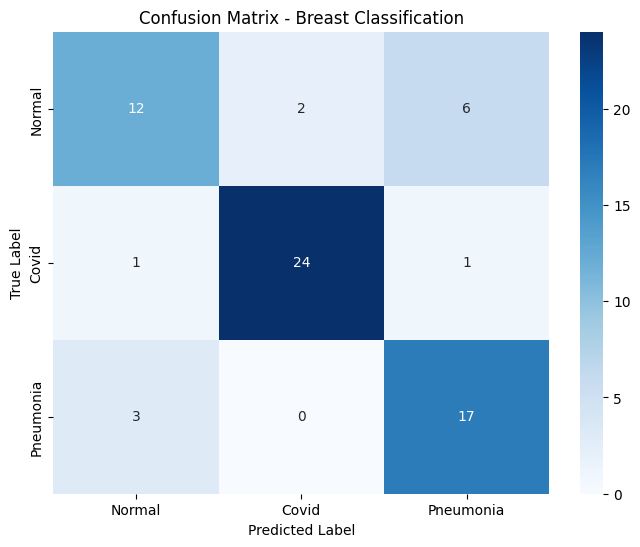

In [134]:
classes_names = ['Normal', 'Covid', 'Pneumonia']
plot_confusion_matrix(y_test, y_pred_test, classes_names)


##2. Recall / Sensitivity (The Safety Net)
Concept: Out of all patients who are actually sick, how many did the model manage to catch? What it tells you: * In medical screening, this is the most important metric. High recall means you are not letting sick patients go home thinking they are healthy.

Low recall leads to Underdiagnosis, which is life-threatening because a disease goes untreated.

## 3. Specificity (The Healthy Confirmation)
Concept: The ability to correctly identify the "Normal" cases. What it tells you: * It measures how good the model is at "clearing" healthy patients.

A high specificity ensures that the medical system isn't clogged with healthy people being sent for secondary biopsies.


In [136]:
print_clinical_metrics(y_test, y_pred_test, classes_names)

,Pathologie,Sensibilité (Recall),Spécificité
0,NORMAL,60.00%,91.30%
1,COVID,92.31%,95.00%
2,PNEUMONIA,85.00%,84.78%


## 4. ROC Curve & AUC (The Diagnostic Power)
Concept: A curve that plots Sensitivity against the False Positive Rate at various threshold settings. What it tells you: * The AUC (Area Under the Curve) provides a single "Quality Score" for the model.

AUC 0.9 - 1.0: Excellent (Clinical Grade).

AUC 0.7 - 0.8: Acceptable but needs improvement.

If one curve (e.g., Covid) is much lower than the others, it tells you that your specific features (like LBP or Hu Moments) are not sufficient to distinguish that specific condition.

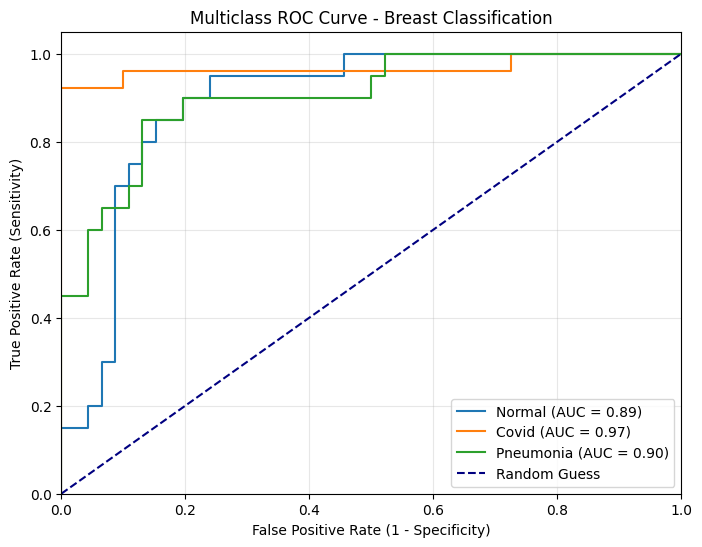

In [137]:
y_score = svm.predict_proba(X_test_pca)
plot_multiclass_roc(y_test, y_score, ['Normal', 'Covid', 'Pneumonia'])

# kNN

In [158]:
print(np.bincount(y_train))

[ 24 138  60]


**The parameter k:** represents the number of neighbors used for classification.
A small k makes the model sensitive to noise, while a large k may cause underfitting.
Optimizing k helps find the best trade-off.

Distance weighting gives more importance to closer neighbors during classification.
This reduces the influence of distant neighbors and improves prediction accuracy, after parameter optimization, the KNN model is trained on the final prepared dataset.
This step allows the model to learn the relationships between samples and their corresponding classes.

In [174]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=9,
    weights='uniform',
    metric='manhattan'
)

knn_model.fit(X_train_pca, y_train_bal)

print(f"Model ready !  {knn_model.n_features_in_} features.")


Model ready !  21 features.


**The confusion matrix:** provides a detailed analysis of model performance for each class.
It highlights classification errors and helps identify the most frequently confused classes.

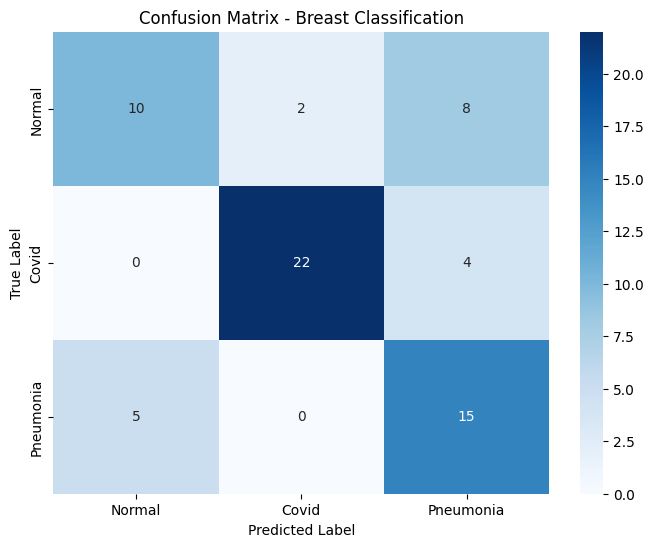

In [180]:
y_pred_pca = knn_model.predict(X_test_pca)
plot_confusion_matrix(y_test, y_pred_pca, classes_names)

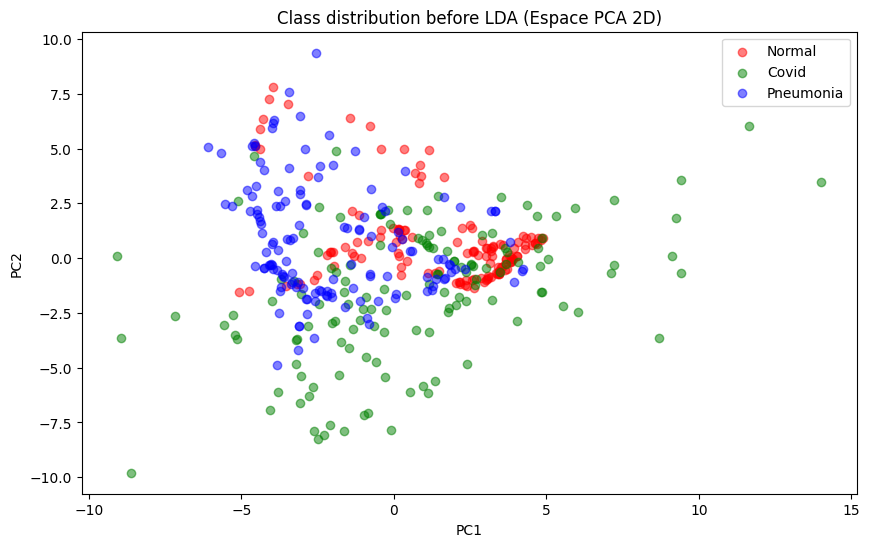

In [181]:
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
classes = ['Normal', 'Covid', 'Pneumonia']

for i, color, label in zip([0, 1, 2], colors, classes):
    plt.scatter(X_train_pca[y_train_bal == i, 0],
                X_train_pca[y_train_bal == i, 1],
                alpha=0.5, c=color, label=label)

plt.title('Class distribution before LDA (Espace PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [182]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_pca, y_train_bal)
X_test_lda = lda.transform(X_test_pca)

knn_lda = KNeighborsClassifier(
    n_neighbors=9,
    weights='uniform',
    metric='manhattan'
)

knn_lda.fit(X_train_lda, y_train_bal)

KNeighborsClassifier(metric='manhattan', n_neighbors=9)

### Division in the LDA Plane

The objective is to completely separate the regions.

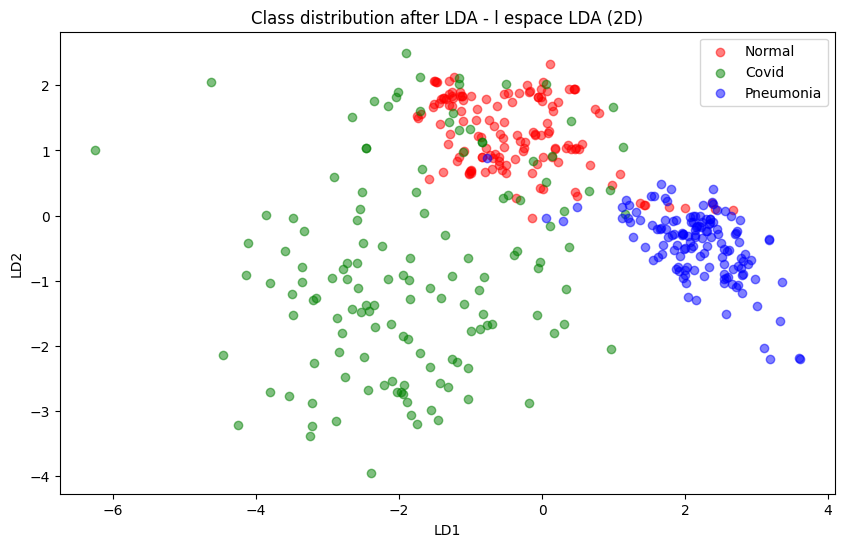

In [183]:
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']
classes = ['Normal', 'Covid', 'Pneumonia']

for i, color, label in zip([0, 1, 2], colors, classes):
    plt.scatter(X_train_lda[y_train_bal == i, 0],
                X_train_lda[y_train_bal == i, 1],
                alpha=0.5, c=color, label=label)

plt.title('Class distribution after LDA - l espace LDA (2D)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend()
plt.show()

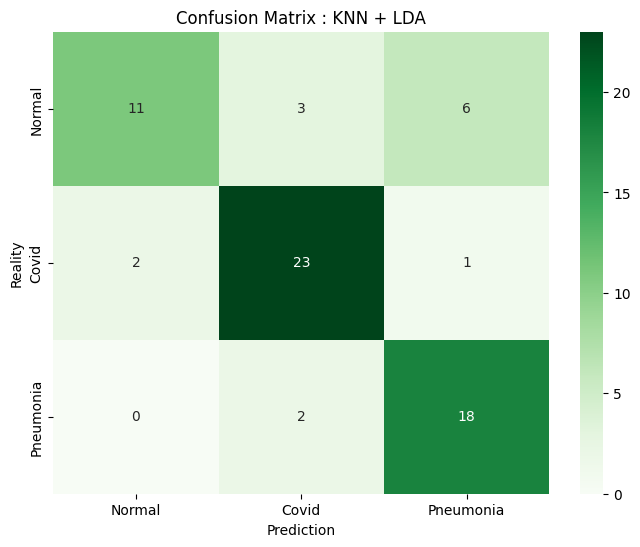

In [184]:
import seaborn as sns

y_pred_lda = knn_lda.predict(X_test_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Covid', 'Pneumonia'],
            yticklabels=['Normal', 'Covid', 'Pneumonia'])
plt.title('Confusion Matrix : KNN + LDA')
plt.xlabel('Prediction')
plt.ylabel('Reality')
plt.show()

In [185]:
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3
classes_names = ['Normal', 'Covid', 'Pneumonia']

# Scores before LDA
y_score_before = knn_model.predict_proba(X_test_pca)

# Scores AFTER LDA
y_score_after = knn_lda.predict_proba(X_test_lda)

/tmp/ipython-input-3268472166.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guess')


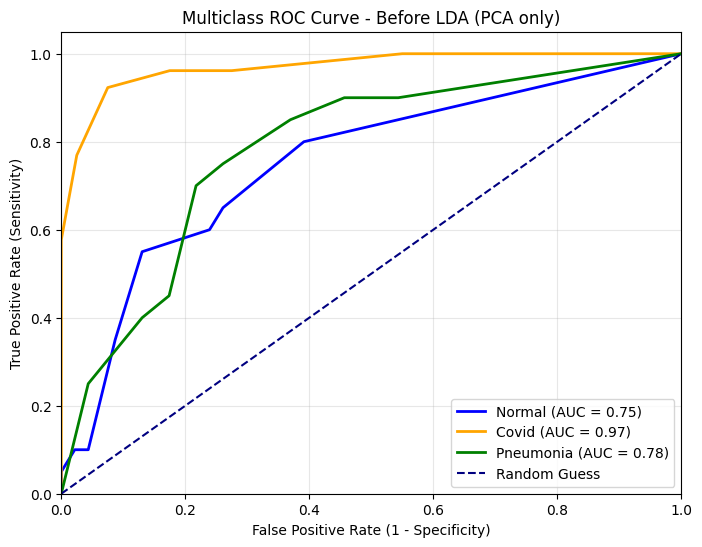

/tmp/ipython-input-3268472166.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guess')


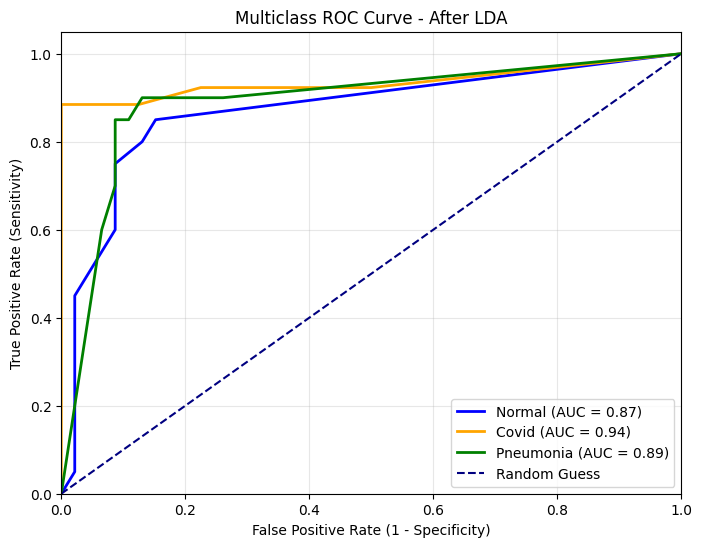

In [186]:
def plot_roc_curves(y_test_bin, y_score, title):
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'orange', 'green']
    n_cols = y_score.shape[1]

    for i in range(n_cols):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        label_text = classes_names[i] if i < len(classes_names) else f"Class {i}"

        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label=f'{label_text} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curves(y_test_bin, y_score_before, "Multiclass ROC Curve - Before LDA (PCA only)")
plot_roc_curves(y_test_bin, y_score_after, "Multiclass ROC Curve - After LDA")

In [187]:
# 1 : KNN seul
print("Report KNN seul :")
print_clinical_metrics(y_test, knn_model.predict(X_test_pca), ['Normal', 'Covid', 'Pneumonia'])

#  2 : KNN + LDA
print("Report KNN + LDA :")
print_clinical_metrics(y_test, knn_lda.predict(X_test_lda), ['Normal', 'Covid', 'Pneumonia'])

Report KNN seul :


,Pathologie,Sensibilité (Recall),Spécificité
0,NORMAL,50.00%,89.13%
1,COVID,84.62%,95.00%
2,PNEUMONIA,75.00%,73.91%


Report KNN + LDA :


,Pathologie,Sensibilité (Recall),Spécificité
0,NORMAL,55.00%,95.65%
1,COVID,88.46%,87.50%
2,PNEUMONIA,90.00%,84.78%


# Ensemble learning

In this section, we implement an Ensemble Learning strategy using a Hierarchical Cascade. Instead of a single voting mechanism, we use a two-tier decision process:

Tier 1 (The Filter): An RBF-Kernel SVM specialized in distinguishing between "Normal" and "Pathological" (Disease) cases, using a high probability threshold to protect the "Normal" class.

Tier 2 (The Specialist): A kNN model trained exclusively to differentiate between Covid and Pneumonia once the "Normal" possibility has been ruled out.

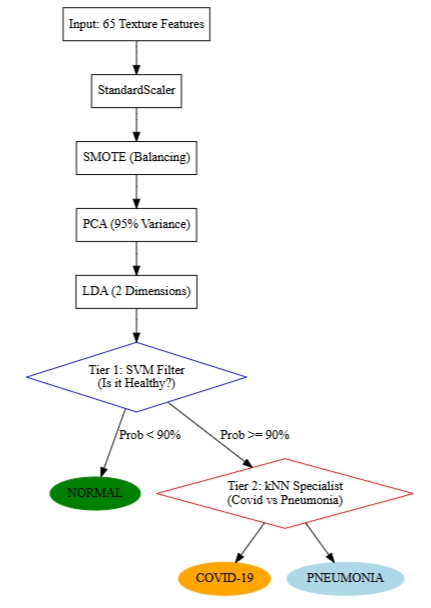

In [188]:
# 1. Prepare binary labels for Tier 1 (0: Normal, 1: Disease)
y_train_bin = (y_train_bal != 0).astype(int)
y_test_bin = (y_test != 0).astype(int)

# 2. Train Tier 1: Health Filter (SVM)
# Using RBF kernel and balanced weights to improve 'Normal' detection
svm_filter = SVC(probability=True, kernel='rbf', gamma='auto', class_weight='balanced')
svm_filter.fit(X_train_lda, y_train_bin)

# 3. Train Tier 2: Disease Specialist (kNN)
# Filter training data to focus only on Covid (1) and Pneumonia (2)
mask_disease = (y_train_bal != 0)
X_train_spec = X_train_lda[mask_disease]
y_train_spec = y_train_bal[mask_disease]

knn_lda.fit(X_train_spec, y_train_spec)

KNeighborsClassifier(metric='manhattan', n_neighbors=9)

## Inference and Evaluation
We use a custom inference function. The threshold=0.9 is critical: it forces the model to be extremely certain before labeling a lung as "Diseased," significantly reducing the false negative rate for the Normal category.

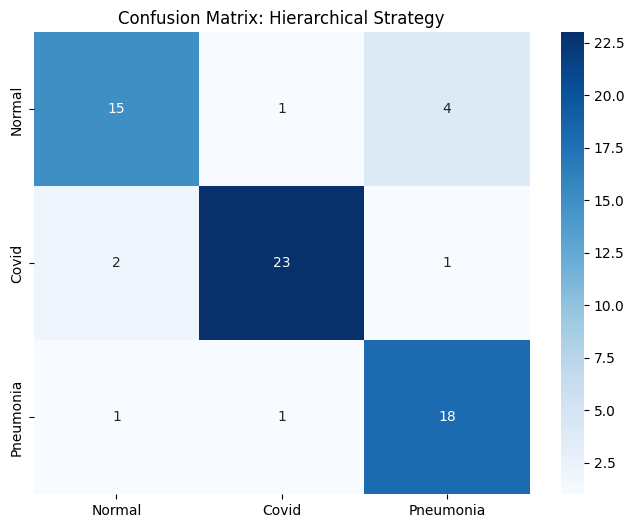

In [189]:
def predict_hierarchical(X, threshold=0.9):
    preds = []
    for sample in X:
        sample_rs = sample.reshape(1, -1)

        # Level 1: Check disease probability
        prob_disease = svm_filter.predict_proba(sample_rs)[0][1]

        if prob_disease < threshold:
            preds.append(0) # Classify as Normal
        else:
            preds.append(knn_lda.predict(sample_rs)[0])
    return np.array(preds)

y_pred_final = predict_hierarchical(X_test_lda)
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Covid', 'Pneumonia'],
            yticklabels=['Normal', 'Covid', 'Pneumonia'])
plt.title('Confusion Matrix: Hierarchical Strategy')
plt.show()

In [190]:
def get_ensemble_probs(X, svm_model, knn_model):
    svm_probs = svm_model.predict_proba(X)
    knn_probs = knn_model.predict_proba(X)
    ensemble_probs = np.zeros((len(X), 3))

    for i in range(len(X)):
        p_normal_svm = svm_probs[i, 0]
        p_maladie_svm = svm_probs[i, 1]
        ensemble_probs[i, 0] = p_normal_svm

        if knn_probs.shape[1] == 2:
            ensemble_probs[i, 1] = p_maladie_svm * knn_probs[i, 0]
            ensemble_probs[i, 2] = p_maladie_svm * knn_probs[i, 1]
        else:
            ensemble_probs[i, 1] = p_maladie_svm * knn_probs[i, 1]
            ensemble_probs[i, 2] = p_maladie_svm * knn_probs[i, 2]
    return ensemble_probs

y_score_ensemble = get_ensemble_probs(X_test_lda, svm_filter, knn_lda)

/tmp/ipython-input-3268472166.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='navy', label='Random Guess')


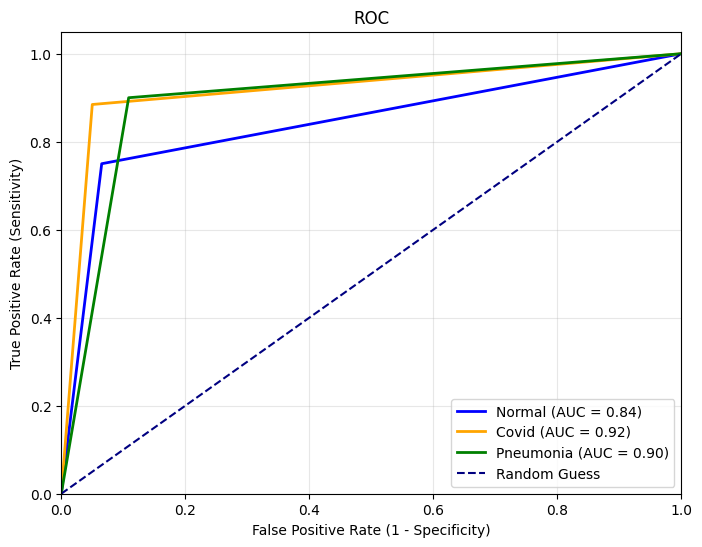

In [191]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score_ensemble = label_binarize(y_pred_final, classes=[0, 1, 2])
plot_roc_curves(y_test_bin, y_score_ensemble, "ROC")

In [192]:
print("Report Ensemble learning:")
print_clinical_metrics(y_test, y_pred_final, ['Normal', 'Covid', 'Pneumonia'])

Report Ensemble learning:


,Pathologie,Sensibilité (Recall),Spécificité
0,NORMAL,75.00%,93.48%
1,COVID,88.46%,95.00%
2,PNEUMONIA,90.00%,89.13%


## Overfitting Diagnostic
Finally, we compare the performance on the training set versus the test set. A high gap indicates the model is memorizing data, while a small gap proves the ensemble has learned general biological patterns.

In [194]:
y_pred_train_final = predict_hierarchical(X_train_lda) # Predictions on Training set

acc_train = accuracy_score(y_train_bal, y_pred_train_final)
acc_test = accuracy_score(y_test, y_pred_final)
gap = (acc_train - acc_test) * 100

print("-" * 30)
print(" OVERFITTING DIAGNOSTIC")
print("-" * 30)
print(f"Train Accuracy: {acc_train:.2%}")
print(f"Test Accuracy:  {acc_test:.2%}")
print(f"Overfitting Gap: {gap:.2f}%")

if gap > 15:
    print("\n[ALERT] High Overfitting.")
elif gap > 5:
    print("\n[OK] Acceptable Generalization.")
else:
    print("\n[EXCELLENT] High Generalization.")

------------------------------
 OVERFITTING DIAGNOSTIC
------------------------------
Train Accuracy: 88.16%
Test Accuracy:  84.85%
Overfitting Gap: 3.32%

[EXCELLENT] High Generalization.
